# P.A.R.S.E.C. - PDF Analysis and Review System for Exam Content

This Jupyter Notebook aims to provide a system for analyzing and reviewing PDF documents related to exam content. The notebook will include various functionalities such as parsing PDF files, extracting text and metadata, performing text analysis, generating visualizations, and facilitating the review process. The goal is to create an efficient and comprehensive system for working with exam-related PDF documents.

## Requirements
- python 3.10~
- Elastic instance w/ ELSER Model
- nvidia gpu or llm api key

# Optional
- Langsmith Account/API key (free tier)


In [1]:
#!python3 -m pip install -qU elasticsearch langchain langchain-elasticsearch openai tiktoken PyPDF4

#%pip install PyPDF4
#%pip install elasticsearch
#%pip install langchain
#%pip install langchain-elasticsearch
#%pip install openai tiktoken
#%pip install wordcloud
#%pip install rapidocr-onnxruntime
#%pip install nltk
#%pip install jq
#%pip install ollama

In [2]:
import os 
import re
# import json
from getpass import getpass
from pypdf import PdfReader, PdfWriter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from urllib.request import urlopen
#from langchain.text_splitter import RecursiveCharacterTextSplitter
#import multiprocessing
#from multiprocessing import Pool
#import importlib
#import json
#from pathlib import Path
#from typing import Callable, Dict, List, Optional, Union, Any
#from langchain.document_loaders.base import BaseLoader
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_elasticsearch import ElasticsearchStore

#from concurrent.futures import ProcessPoolExecutor
#from tqdm import tqdm
#import jq
#from langchain_community.document_loaders import JSONLoader # for non-windows users I suppose


# Download the Punkt tokenizer models (only needed once)
#nltk.download('punkt')

# Preparation of the PDF Files
Get rid of pesky passwords


In [3]:
cwd = os.getcwd()
pdf_files = [f for f in os.listdir(cwd) if f.endswith('.pdf')]
print(pdf_files)

['decrypted_SEC595 - Book 1_2036060.pdf', 'decrypted_SEC595 - Book 2_2036060.pdf', 'decrypted_SEC595 - Book 3_2036060.pdf', 'decrypted_SEC595 - Book 4_2036060.pdf', 'decrypted_SEC595 - Book 5_2036060.pdf', 'decrypted_SEC595 - Book 6_2036060.pdf', 'decrypted_SEC595 - Workbook 1_2036060.pdf', 'decrypted_SEC595 - Workbook 2_2036060.pdf', 'SEC595 - Book 1_2036060.pdf', 'SEC595 - Book 2_2036060.pdf', 'SEC595 - Book 3_2036060.pdf', 'SEC595 - Book 4_2036060.pdf', 'SEC595 - Book 5_2036060.pdf', 'SEC595 - Book 6_2036060.pdf', 'SEC595 - Workbook 1_2036060.pdf', 'SEC595 - Workbook 2_2036060.pdf']


In [4]:
# Skip if already run before
if 'decrypted_'+pdf_files[-1] in os.listdir(cwd):
    print('Already decrypted')
else:
    # Decrypt the PDF files
    for i, pdf_file in enumerate(pdf_files):
        if pdf_file.startswith('decrypted_'):
            continue
        with open(pdf_file, 'rb') as file:
            print(pdf_file, ' is decrypting')
            reader = PdfReader(file)
            # Attempt to decrypt the PDF with an empty password
            if reader.is_encrypted:
                try:
                    reader.decrypt('PpH[uQ(7+Gy:FdA9;X9QVXi@$zVwD-') # Your password here
                except:
                    print("The PDF is encrypted and cannot be decrypted with the password.")
                    break
            
            writer = PdfWriter()
            
            # Copy the content from the original PDF to the new PDF
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                writer.add_page(page)
            
            # Save the new PDF file without encryption
            with open('decrypted_'+pdf_files[i], 'wb') as output_file:
                writer.write(output_file)
            print("The PDF has been successfully decrypted.")

Already decrypted


# Extracting text and metadata
We'll load the decrypted pdfs, split pages, and so on.
There are books and workbooks within the provided materials and they both require some cleaning. Basically everything after the SANS copyright is useless. For each book we'll take two slices of pages, [4:-1] & [-1]. The former is the course content and the latter is the provided index. For workbooks, we only need one slice [4:]


In [5]:
cwd = os.getcwd()
pdfs = [f for f in os.listdir(cwd) if f.startswith('decrypted_')]


indexes = []
contents = []
for pdf in pdfs:
    loader = PyPDFLoader(pdf)
    pages = loader.load_and_split()
    if 'Workbook' in pages[0].metadata['source']:
        contents.append(pages[4:])
    else:
        contents.append(pages[4:-1])
        indexes.append(pages[-1])

len(indexes), len(contents)

(6, 8)

In [6]:
def clean_document(page_content):
    """
    Clean the document content by removing headers, footers, and any licensing or copyright information.
    """
    cleaned_content = re.sub(r'©.*?SANS Institute \d{4}.*', '', page_content, flags=re.DOTALL)
    cleaned_content = re.sub(r'\S+@\S+', '', cleaned_content)
    cleaned_content = re.sub(r'\s+z', ' ', cleaned_content)
    return cleaned_content

for index in indexes:
    index.page_content = clean_document(index.page_content)

for book in contents:
    for page in book:
        page.page_content = clean_document(page.page_content)


In [7]:
contents[0][0].page_content

'This course was conceived and authored by David Hoelzer. David is the COO of Enclave Forensics,\nInc., a managed security monitoring company. He also serves as Dean of Faculty for the SANS\nTechnology Institute and a Faculty Fellow for The SANS Institute.\nDavid has been working in the IT and Information Security fields since the late 1980s. In addition to\ndaily work in network monitoring, analysis, and secure development, he leads the machine learning\ninitiatives within Enclave. His particular area of focus is supervised learning solutions for real-time\nmonitoring and classification of enterprise network activities.\n3'

In [8]:
def split_pages(book, max_length=512):
    """
    Recursively splits the content of each page in a book into chunks of no more than max_length characters.
    Returns a list of Document objects containing the split chunks.
    """
    processed_pages = []
    for page in book:
        cleaned_content = page.page_content.strip().replace('\n', ' ')
        if len(cleaned_content) <= max_length:
            # Content is short enough, no need to split
            processed_pages.append(Document(cleaned_content, metadata=page.metadata.copy()))
        else:
            # Split the content recursively
            processed_pages.extend(split_content(cleaned_content, max_length, page.metadata))
    return processed_pages

def split_content(content, max_length, metadata):
    """
    Recursively splits the given content into chunks of no more than max_length characters.
    Returns a list of Document objects containing the split chunks, with the provided metadata.
    """
    if len(content) <= max_length:
        return [Document(content, metadata=metadata.copy())]
    
    # Find the last period before the max_length limit
    last_period_idx = content[:max_length].rfind('.')
    
    if last_period_idx == -1:
        # No period found, split at max_length
        return [Document(content[:max_length], metadata=metadata.copy())] + split_content(content[max_length:], max_length, metadata)
    else:
        # Split at the last period and recurse on the remaining text
        chunk = content[:last_period_idx+1]  # Include the period
        remaining = content[last_period_idx+1:].strip()
        return [Document(chunk, metadata=metadata.copy())] + split_content(remaining, max_length, metadata)

In [9]:
processed_data = []
for book in contents:
    processed_data.extend(split_pages(book))

In [10]:
type(processed_data[0]), len(processed_data), print(processed_data[0].page_content)

This course was conceived and authored by David Hoelzer. David is the COO of Enclave Forensics, Inc., a managed security monitoring company. He also serves as Dean of Faculty for the SANS Technology Institute and a Faculty Fellow for The SANS Institute. David has been working in the IT and Information Security fields since the late 1980s. In addition to daily work in network monitoring, analysis, and secure development, he leads the machine learning initiatives within Enclave.


(langchain_core.documents.base.Document, 3401, None)

# Ship docs to for text expansion

In [11]:
# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
ELASTIC_CLOUD_ID = getpass("Elastic Cloud ID: ")

ELASTIC_URL = getpass("Elastic URL")

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic Api Key: ")



In [12]:
vector_store = ElasticsearchStore(
    es_url=ELASTIC_URL,
    es_api_key=ELASTIC_API_KEY,
    index_name="sec595",
)

In [13]:
INDEX_NAME = "sec595"

SHOULD_DELETE_INDEX = True

if SHOULD_DELETE_INDEX:
    if vector_store.client.indices.exists(index=INDEX_NAME):
        vector_store.client.indices.delete(index=INDEX_NAME, ignore=[400, 404])


documents = vector_store.from_documents(
processed_data,
es_url=ELASTIC_URL,
es_api_key=ELASTIC_API_KEY,
index_name=INDEX_NAME,
strategy=ElasticsearchStore.SparseVectorRetrievalStrategy(
    model_id=".elser_model_2_linux-x86_64"
),
bulk_kwargs={
    "request_timeout": 60,
},
)


C:\Users\nc\AppData\Local\Temp\ipykernel_19956\781378470.py:7: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  vector_store.client.indices.delete(index=INDEX_NAME, ignore=[400, 404])


In [14]:
def showResults(output):
    print("Total results: ", len(output))
    for index in range(len(output)):
        print(output[index])

In [15]:

documents.client.indices.refresh(index="sec595")

results = documents.similarity_search(
    "Summarize Bag of Words?", k=4, strategy=ElasticsearchStore.SparseVectorRetrievalStrategy(
    model_id=".elser_model_2_linux-x86_64"
)
)
showResults(results)

Total results:  4
page_content='One of the most important is that when the system is learning, which we should clearly understand to mean automatically updating coefficients to approximate a function that minimizes loss, our network does not understand the movie reviews or the emails at all! The approach to representing our data is called Bag of Words. This name derives from the fact that we are simply tracking which words are used, completely disregarding the order that the words are in2.' metadata={'source': 'decrypted_SEC595 - Book 4_2036060.pdf', 'page': 46}
page_content='If you consider the two following sentences, you will appreciate why this is such a big problem: You did understand Did you understand Both of these sentences contain the same words and they would be encoded identically under Bag of Words. Bag of Words also doesn’t preserve the number of times any given word appears in a piece of text. Since we are looking to preserve word order and context, we need a way to encod

# Build the baseline index

In [16]:
idx = []
for index in indexes:
    lines = index.page_content.split('\n')
    records = []
    i = 0
    j = 0
    for line in lines[1:]:
        if not re.match(r'^\d+', line):
            records.append(line)
            txt = line.split(',')
            idx.append({'topic': txt[0], 'book': index.metadata['source'], 'pages': [tx.strip() for tx in txt[1:]]})
            topic = txt[0]
            j = int(i)
            i += 1
        else:
            if j < len(records):
                records[j] = records[j] + ' ' + line
                txt = line.split(', ')
                idx[j]['pages'] = idx[j]['pages'] + txt[:]
                i += 1


In [17]:
import pandas as pd

# This function is like 99% there. I broke my brain trying to handle the edge cases.
# Since there are two columns, it is sometimes difficult to know when to start a new topic.

df = pd.DataFrame(idx)
df = df.explode('pages')
# group by topic and book
df = df.groupby(['topic', 'book'])['pages'].apply(list).reset_index()
df['book'] = df['book'].apply(lambda x: x.split(' - ')[1].split('_')[0])

for i, row in df.iterrows():
    for j, page in enumerate(row['pages']):
        if isinstance(page, str):
            if re.search(r'[a-zA-Z]', page):
                if re.search(r'[0-9]', page):
                    # Get topic for new row
                    newtopic = re.match(r"\d{1,3}(.*)", page).group(1)
                    # Adjust value of current page to only contain the digits
                    row['pages'][j] = re.match(r"(\d{1,3}).*", page).group(0)
                    newpages = row['pages'][j+1:]
                    row['pages'] = row['pages'][:j-1]
                    print(f'topic: {newtopic} pages {str(newpages)} row: {row["topic"]}')
                    dfx = pd.DataFrame({'topic': newtopic, 'book': [row['book']], 'pages': [newpages]})
                    df = pd.concat([df, dfx], axis=0)
                    
# sort df by book and  topic
df = df.sort_values(by=['book', 'topic']).reset_index(drop=True)
# drop rows with null page
df = df.dropna(subset=['pages'])
# aggregate by topic & book then deduplicate the items in pages list
df = df.groupby(['topic', 'book'])['pages'].apply(lambda x: list(set([item for sublist in x for item in sublist]))).reset_index()
# sort the values in each row for pages even if its a str
df['pages'] = df['pages'].apply(lambda x: sorted(x, key=lambda y: str(y)))
# get rid of empty values in the pages list
df['pages'] = df['pages'].apply(lambda x: [i for i in x if i])
df.head()

topic: Epsilon pages ['seeDBSCAN'] row: Elbow Method
topic: latentspace pages ['22'] row: Huberloss
topic: Leaky Rectified Linear Unit pages ['52', '53'] row: IMDB dataset
topic: linear regression pages ['6'] row: IMDB dataset
topic: normal forms pages ['63', '74', '89', '90', '94', '95'] row: MongoEngine
topic: NumPy pages ['3', '7'] row: NetFlow


,topic,book,pages
0,Anaconda,Book 1,"[10, 11, 47, 74, 8]"
1,BackBlaze,Book 2,[28]
2,Bag of Words,Book 4,[45]
3,Bayes Theorem,Book 2,[56–58]
4,Bayesian,Book 4,[45]


In [58]:
df.shape

(179, 3)

# Let's do Elastic Stuff


In [18]:
from elasticsearch import Elasticsearch
# Create a connection to Elasticsearch
es = Elasticsearch(
    ELASTIC_URL,
    api_key=ELASTIC_API_KEY
)


In [19]:
es.info()

ObjectApiResponse({'name': 'serverless', 'cluster_name': 'ca9a9d90a7e44baab2629c85cc6ba7ea', 'cluster_uuid': 'uoMZYkwSR9auvQUhIRxtXQ', 'version': {'number': '8.11.0', 'build_flavor': 'serverless', 'build_type': 'docker', 'build_hash': '00000000', 'build_date': '2023-10-31', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '8.11.0', 'minimum_index_compatibility_version': '8.11.0'}, 'tagline': 'You Know, for Search'})

In [ ]:
model = '.elser_model_2_linux-x86_64'
# Perform a query
query = {
    "_source": {"includes": ["metadata*", "text"]},
   "query":{
      "text_expansion":{
         "vector.tokens":{
            "model_id":model,
            "model_text":"What is bag of words"
         }
      }
   }
}

# Search the index
response = es.search(index=INDEX_NAME, body=query, )

temp = []
# Process the response
for hit in response['hits']['hits']:
    temp += ' '+hit['_source']['text']


In [49]:
import litellm
from litellm import completion


litellm.api_base = 'http://192.168.0.220:4000'
litellm.api_key = getpass("Litellm")
# get models


In [50]:
response = completion(
    model="groq/llama3-70b-8192", 
    messages=[
       {"role": "user", "content": "hello from litellm"}
   ],
)
print(response)



ModelResponse(id='chatcmpl-d92cbba2-794a-4826-8f3b-b11f4063a51a', choices=[Choices(finish_reason='stop', index=0, message=Message(content="Hello there! It's nice to meet you, Littlem! Is there something I can help you with, or would you like to chat about something in particular?", role='assistant'))], created=1713622948, model='groq/llama3-70b-8192', object='chat.completion', system_fingerprint='fp_f904dafd15', usage=Usage(completion_tokens=33, prompt_tokens=15, total_tokens=48))


In [56]:
response.choices[0].message.content

"Hello there! It's nice to meet you, Littlem! Is there something I can help you with, or would you like to chat about something in particular?"

# Generate Summaries

In [59]:
# For each row in the dataframe, 
# create query & search Elastic for top n documents
# combine the results into a single string
# create prompt for the topic & submit to llm for summarization
# add the summary to the dataframe

from tqdm import tqdm
import litellm
from litellm import completion

litellm.api_base = 'http://192.168.0.220:4000'
litellm.api_key = getpass("Litellm")

model = '.elser_model_2_linux-x86_64'
df['summary'] = ''

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    topic = row['topic']
    query =  {
    "_source": {"includes": ["metadata*", "text"]},
        "query":{
            "text_expansion":{
                "vector.tokens":{
                    "model_id": model,
                    "model_text":f"Describe the concept/topic of {topic}"
                }}}}
    res = es.search(index=INDEX_NAME, body=query, size=5)

    # Combine the results into a single string
    material = ''
    for hit in res['hits']['hits']:
        material += hit['_source']['text']+' '

    prompt = f"Summarize the following text on the topic of {topic}: {material}"

# submit to llm for summarization
    response = completion(
        model="groq/llama3-70b-8192", 
        messages=[
            {"role": "user", "content": prompt}
        ],
    )
    df.at[i, 'summary'] = response.choices[0].message.content

  0%|          | 0/179 [00:00<?, ?it/s]C:\Users\nc\AppData\Local\Temp\ipykernel_19956\2696127869.py:27: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  res = es.search(index=INDEX_NAME, body=query, size=5)
100%|██████████| 179/179 [15:49<00:00,  5.30s/it]


In [61]:
# Save the dataframe to a csv file
df.to_csv('summary.csv', index=False)

# Stricter Sum-of-summary

In [63]:
df['summary_strict'] = ''
base_prompt = """Create a concise and informative summary (no more than 100 words) for a given topic 
based primarily on the given documents. You must prefer using information from the given documents. 
Use an unbiased and journalistic tone. Do not repeat text. The summary must preserve any components useful for an open book exam so you can exceed the word limit if absolutely necessary.
"""
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    # add check in case of mid run failures
    if row['summary_strict']:
        continue
    else:
        topic = row['topic']
        summary = row['summary']

        prompt = f"{base_prompt} topic: {topic}, content: {summary}"
        
        # submit to llm for summarization
        response = completion(
            model="groq/llama3-70b-8192", 
            messages=[
                {"role": "user", "content": prompt}
            ],
        )


        df.at[i, 'summary_strict'] = response.choices[0].message.content

  0%|          | 0/179 [00:00<?, ?it/s]

In [ ]:
df.to_csv('summary_strict.csv', index=False)

# Strict Doc QA
Create a concise and informative summary (no more than 100 words) for a given topic 
based primarily on the given documents. You must prefer using information from the given documents. 
Use an unbiased and journalistic tone. Do not repeat text. The summary must preserve any components useful for an open book exam so you can exceed the word limit if absolutely necessary.
Topic: {summary}; Summary: 

# rewrite
I will give you text content, you will rewrite it and output a better version of my text.
Keep the meaning the same. Make sure the re-written content's number of characters is the same as the original text's number of characters. Do not alter the original structure and formatting outlined in any way. Only give me the output and nothing else.
Now, using the concepts above, re-write the following text. Respond in the same language variety or dialect of the following text:

"""  
{{text}}  
"""

# NoteGPT
You are NotesGPT, an AI language model skilled at taking detailed, concise, succinct, and easy-to-understand notes on various subjects in bullet-point advanced markdown format. When provided with a passage or a topic, your task is to:

-Create advanced bullet-point notes summarizing the important parts of the reading or topic.
-Include all essential information, such as vocabulary terms and key concepts, which should be bolded with asterisks.
-Remove any extraneous language, focusing only on the critical aspects of the passage or topic.
-Strictly base your notes on the provided text, without adding any external information.
-Conclude your notes with [End of Notes, Message #X] to indicate completion, where "X" represents the total number of messages that I have sent. In other words, include a message counter where you start with #1 and add 1 to the message counter every time I send a message.

---

# Generating visualizations

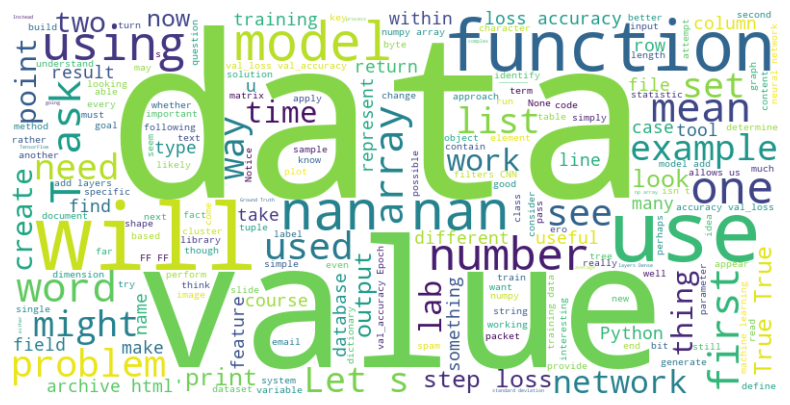

In [23]:
from wordcloud import WordCloud

def generate_word_cloud(text):
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Example usage
generate_word_cloud(' '.join([page.page_content for page in processed_data]))

# Facilitating the review process

In [24]:
# Preparation & Parsing of the PDF Files

 